In [1]:
#import libraries 
import logging
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from umap import UMAP
import matplotlib.pyplot as plt
from reval.best_nclust_cv import FindBestClustCV

In [2]:
# define paths
main_path = '/Users/vmandelli/OneDrive - Fondazione Istituto Italiano Tecnologia/vine_old'
data_path = os.path.join(main_path,"data","tidy","vineland_210722")
results_path = os.path.join(main_path,"results")
plot_path = os.path.join(main_path,"plot")

In [3]:
# load file
file = 'VABS_ASD_older_than72_1timepoint_20220726.csv'
df = pd.read_csv(os.path.join(data_path,file),
                        header=0,
                        #skiprows=[1],
                        low_memory=False,
                        index_col='subjectkey')

#df.drop('Unnamed: 0', 1, inplace = True)
df.head(5)

,collection_id,src_subject_id,sex,interview_age,interview_date,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,collection_id.1,edition,vabs_type,miss,age_round
subjectkey,,,,,,,,,,,,,,,
NDARUR864GDR,2026,3005,M,73,08/13/2013,36.0,41.0,48.0,61.0,44.0,2026,2,survey,0,6.083333
NDARUZ978TZ7,1,168-3372,M,73,01/27/2009,69.0,64.0,59.0,78.0,64.0,1,2,survey,0,6.083333
NDARDA487RHJ,2262,212,F,73,04/16/2016,74.0,66.0,57.0,56.0,61.0,2262,2,survey,0,6.083333
NDARJW531AVE,1,168-3776,M,73,10/07/2009,72.0,85.0,61.0,100.0,76.0,1,2,survey,0,6.083333
NDARPM369WUN,2020,20013,M,73,04/28/2015,42.0,51.0,53.0,56.0,49.0,2020,2,survey,0,6.083333


In [4]:
#set columns name for those I want to include (remember, exclude motor subtyping, it is for young subjects only!)
vabs_names = ['communicationdomain_totalb','livingskillsdomain_totalb',
              'socializationdomain_totalb']
col2use=vabs_names

In [5]:
# exclude very old subjects- maybe data entry error?
df = df[df['interview_age']<780]

In [6]:
# define age quantiles for stratification vector
df['quantile_age'] = pd.qcut(df['interview_age'], 10,labels=range(10))
df['sex']=df['sex'].str.upper()
df.head(500)

,collection_id,src_subject_id,sex,interview_age,interview_date,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,collection_id.1,edition,vabs_type,miss,age_round,quantile_age
subjectkey,,,,,,,,,,,,,,,,
NDARUR864GDR,2026,3005,M,73,08/13/2013,36.0,41.0,48.0,61.0,44.0,2026,2,survey,0,6.083333,0
NDARUZ978TZ7,1,168-3372,M,73,01/27/2009,69.0,64.0,59.0,78.0,64.0,1,2,survey,0,6.083333,0
NDARDA487RHJ,2262,212,F,73,04/16/2016,74.0,66.0,57.0,56.0,61.0,2262,2,survey,0,6.083333,0
NDARJW531AVE,1,168-3776,M,73,10/07/2009,72.0,85.0,61.0,100.0,76.0,1,2,survey,0,6.083333,0
NDARPM369WUN,2020,20013,M,73,04/28/2015,42.0,51.0,53.0,56.0,49.0,2020,2,survey,0,6.083333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARVF019FMR,6,10946,M,94,07/09/2009,86.0,83.0,75.0,999.0,79.0,6,2,parent,0,7.833333,1
NDARMK862FP7,2025,9332,M,94,06/11/2016,90.0,74.0,68.0,88.0,76.0,2025,2,survey,0,7.833333,1
NDARBN123AKA,2072,654,F,94,01/13/2016,90.0,81.0,87.0,999.0,84.0,2072,2,survey,0,7.833333,1


(2561, 16)


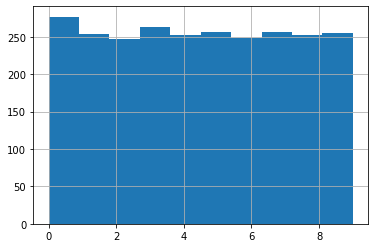

In [7]:
# check quantile distribution
df['quantile_age'].hist()
print(df[['sex','quantile_age']].value_counts().sort_index())
print(df.shape)

In [9]:
# train and test split
strat_vect = df['sex'] + df['quantile_age'].astype("str")
X_tr_split, X_ts_split = train_test_split(df,
                             stratify = strat_vect,
                             test_size=0.33,
                             random_state=42)
print('there are ',X_tr_split.shape,' subject in the train set')
print('there are ',X_ts_split.shape,' subject in the test set')

there are  (1715, 16)  subject in the train set
there are  (846, 16)  subject in the test set


In [10]:
X_tr_split

,collection_id,src_subject_id,sex,interview_age,interview_date,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,collection_id.1,edition,vabs_type,miss,age_round,quantile_age
subjectkey,,,,,,,,,,,,,,,,
NDARFU868CVF,2179,9239.04,F,194,09/22/2015,87.0,97.0,85.0,999.0,85.0,2179,2,survey,0,16.166667,7
NDARKH503DN3,2030,B1010,M,128,02/28/2013,100.0,100.0,80.0,999.0,92.0,2030,2,survey,0,10.666667,4
NDARKD544UEY,2288,V75W5544,M,118,11/21/2016,76.0,79.0,70.0,NaN,74.0,2288,3,3,0,9.833333,3
NDARBF966JBB,2251,7901-05-018,F,101,07/15/2019,57.0,62.0,64.0,56.0,61.0,2251,2,survey,0,8.416667,2
NDAR_INV9F25DLHG,2900,KB103,M,115,05/15/2020,90.0,93.0,84.0,999.0,86.0,2900,2,parent,0,9.583333,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARLA169VFF,6,11657,M,273,09/13/2010,25.0,63.0,35.0,999.0,39.0,6,2,parent,0,22.750000,9
NDARUH788EPP,6,10200,M,176,04/10/2009,124.0,117.0,61.0,999.0,101.0,6,2,parent,0,14.666667,6
NDARCN442MUA,2120,223,M,193,08/28/2015,67.0,81.0,71.0,999.0,71.0,2120,2,survey,0,16.083333,7


In [11]:
# preprocessing

# imputation
impute = KNNImputer(n_neighbors=5)

# scaling  
Scaler = StandardScaler()

#umap
Umap = UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42)

# impute then scale than UMAP
X_tr_prepr = pd.DataFrame(Umap.fit_transform(Scaler.fit_transform(impute.fit_transform(X_tr_split[col2use]))), index = X_tr_split.index)
X_ts_prepr = pd.DataFrame(Umap.transform(Scaler.transform(impute.transform(X_ts_split[col2use]))), index = X_ts_split.index)



In [12]:
print(len(df.index))
print(len(X_tr_split.index))
print(len(X_ts_split.index))


2561
1715
846


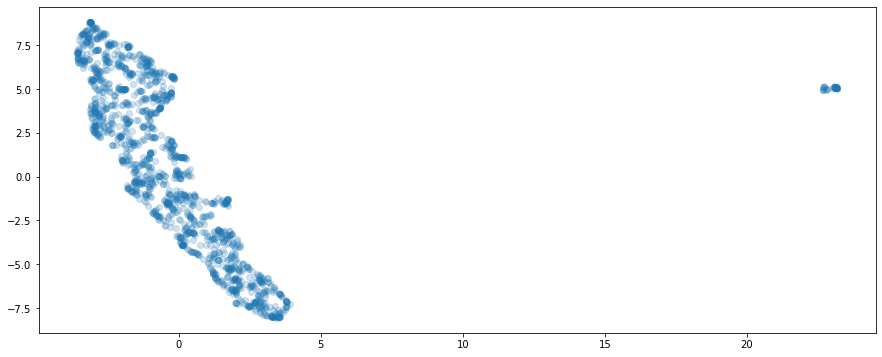

In [13]:
#check imput umap plot
plt.figure(figsize=(15,6))
plt.scatter(X_tr_prepr[[0]], X_tr_prepr[[1]],alpha=0.2)

In [14]:
def Gridsearch(X_tr,strat_vect):

    
    # GRID SEARCH
    
    # initialize impty saving matrices
    #metric_df = pd.DataFrame()
    metric_dict ={'fold': [],"n_neigh":[],'ncl':[],'stab':[],'err':[]}
    
    
    # define params to test
    # KMEANS
    clust = KMeans(random_state=42)
    vect_hyper = [5,15,30]
    
    
    vect_fold = [2]
    
    # run the grid search
    for f in vect_fold:
        for n in vect_hyper:
            logging.info(f"fold:{f} -- nighbors:{n}")
            clf = KNeighborsClassifier(n_neighbors=n)
            #clf = RandomForestClassifier(n_estimators=n)
            relval = FindBestClustCV(s=clf, c=clust, nfold=f, nclust_range=list(range(2,11,1)), nrand=100)
            metric, ncl,_ = relval.best_nclust(X_tr,iter_cv=100, strat_vect = strat_vect) 
            metric_dict['fold'].append(f)
            metric_dict['n_neigh'].append(n)
            metric_dict['ncl'].append(ncl)
            metric_dict['stab'].append(metric['val'][ncl][0])
            metric_dict['err'].append(metric['val'][ncl][1][1])

    metric_df = pd.DataFrame(metric_dict)

    return metric_df


In [15]:
len(X_tr_prepr.index.unique())

1715

In [16]:
# define dataset
X_tr = X_tr_prepr
X_ts = X_ts_prepr
X_tr_indx = X_tr.index
strat_vect = strat_vect[X_tr_indx]

In [17]:
print(len(X_tr_prepr))
print(len(X_tr_indx))
print(len(strat_vect))

1715
1715
1715


In [18]:
# run grid search
metric_df_VABS_old = Gridsearch(X_tr , strat_vect)

10:01:43, INFO fold:2 -- nighbors:5
11:14:09, INFO fold:2 -- nighbors:15
12:38:37, INFO fold:2 -- nighbors:30


In [19]:
# check grid search outputs
mean_stab_err = list(metric_df_VABS_old[["stab","err"]].apply(np.mean,1))
idx = mean_stab_err.index(min(mean_stab_err))
num_neigh = pd.to_numeric(metric_df_VABS_old.loc[idx]['n_neigh']).astype(np.int64)

In [20]:
# save frid search outputs
metric_df_VABS_old.to_csv(os.path.join(results_path,'Grid_search_280722.csv'))

In [22]:
#check number of neigh
num_neigh

5

In [23]:
# run reval (only the train)
# classifcation algorhythm
clf = KNeighborsClassifier(n_neighbors= num_neigh)      #KNN  
# cluster algorhythm
clust = KMeans(random_state=42)                #Kmeans

# define dataset
X_tr = X_tr_prepr
X_ts = X_ts_prepr
X_tr_indx = X_tr.index
strat_vect = strat_vect[X_tr_indx]


# initialize the class
relval = FindBestClustCV(s=clf, c=clust, nfold=2, nclust_range=list(range(2,11,1)), nrand=100)
    
# train
metric, ncl,_ = relval.best_nclust(X_tr,iter_cv=100, strat_vect = strat_vect)
print(metric)
print(ncl)

out = relval.evaluate(X_tr, X_ts, ncl) # riscrivi NCL qui! il best!

logging.info(f"Training ACC: {out.train_acc}, Test ACC: {out.test_acc}")

15:50:35, INFO Training ACC: 0.9994169096209913, Test ACC: 0.9940898345153665


{'train': {2: (0.0017610015422150915, (0.0017610015422150915, 0.0002632146699817107)), 3: (0.0005365453294274825, (0.0005365453294274825, 0.00012154186540759794)), 4: (0.0023964852727980154, (0.0023964852727980154, 0.00020710418447899778)), 5: (0.004221609778785985, (0.004221609778785985, 0.0002719122515946277)), 6: (0.006536421571427397, (0.006536421571427397, 0.00032273340954417094)), 7: (0.006950364882103503, (0.006950364882103503, 0.00037708233000791845)), 8: (0.008011399335786732, (0.008011399335786732, 0.00036971270745874866)), 9: (0.008851151765387472, (0.008851151765387472, 0.00045706125293159226)), 10: (0.010518682018098588, (0.010518682018098588, 0.0004589718262681078))}, 'val': {2: (0.2626732331600667, (0.2626732331600667, 0.055704199645380405)), 3: (0.0037856347033572626, (0.0037856347033572626, 0.0005045890476242929)), 4: (0.0231366016965783, (0.0231366016965783, 0.0028022065184847324)), 5: (0.04662709335191967, (0.04662709335191967, 0.01096053901253441)), 6: (0.1302163319

In [24]:
ncl

3

9


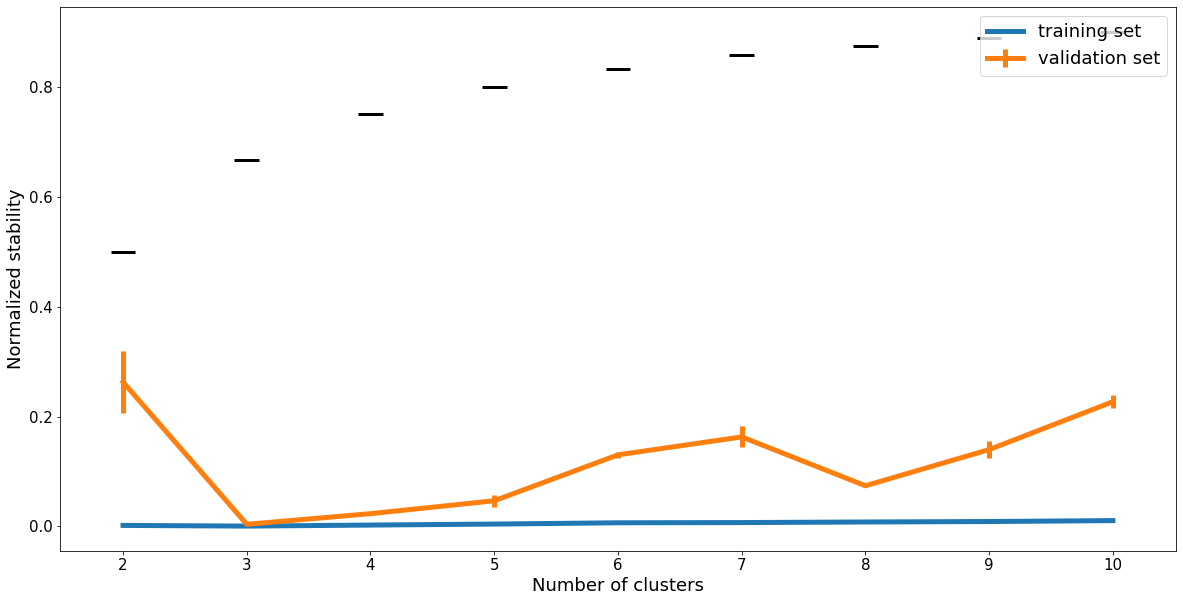

In [25]:
from reval.visualization import plot_metrics
plot_metrics(metric)

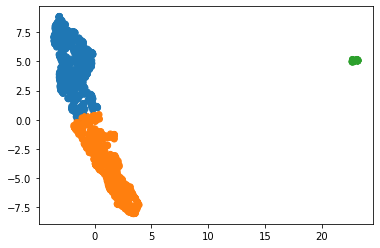

In [26]:
#umap plot train
import matplotlib.pyplot as plt
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.scatter(X_tr_prepr[[0]], X_tr_prepr[[1]], color=[colors[lab] for lab in out.train_cllab])

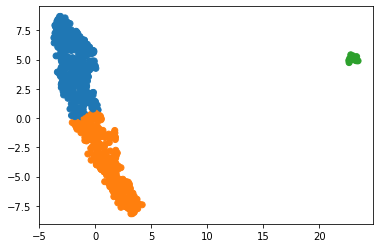

In [27]:
plt.scatter(X_ts_prepr[[0]], X_ts_prepr[[1]], color=[colors[lab] for lab in out.test_cllab])

In [28]:
X_tr_split['cluster_domain']=  out.train_cllab
X_tr_split["TR_TS"] = "TR"

X_ts_split['cluster_domain']=  out.test_cllab
X_ts_split["TR_TS"] = "TS"

<ipython-input-28-a8659a9503c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_split['cluster_domain']=  out.train_cllab
<ipython-input-28-a8659a9503c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_split["TR_TS"] = "TR"
<ipython-input-28-a8659a9503c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

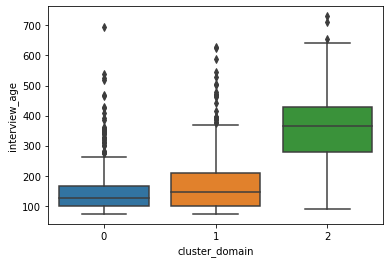

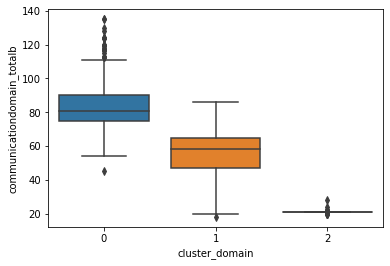

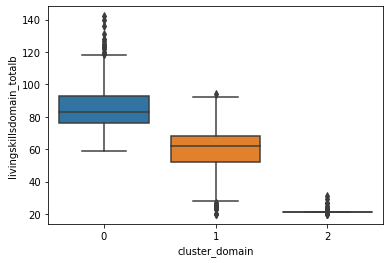

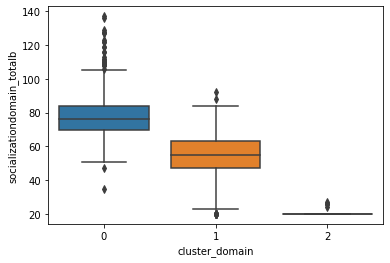

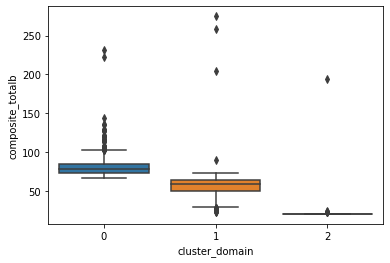

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
dataset_trts_cl = X_tr_split.append(X_ts_split)
cols = ['interview_age', 'communicationdomain_totalb','livingskillsdomain_totalb','socializationdomain_totalb','composite_totalb']
for c in cols:
    _data_train = dataset_trts_cl.loc[dataset_trts_cl['TR_TS']=='TR',]
    plt.figure()
    sns.boxplot(x="cluster_domain", y=c, data=_data_train)


In [30]:
X_tr_split.groupby(['cluster_domain']).count()

,collection_id,src_subject_id,sex,interview_age,interview_date,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,collection_id.1,edition,vabs_type,miss,age_round,quantile_age,TR_TS
cluster_domain,,,,,,,,,,,,,,,,,
0,858,858,858,858,858,858,858,858,679,851,858,858,858,858,858,858,858
1,801,801,801,801,801,800,801,801,672,786,801,801,801,801,801,801,801
2,56,56,56,56,56,56,56,56,50,56,56,56,56,56,56,56,56


In [31]:
X_ts_split.groupby(['cluster_domain']).mean()

,collection_id,interview_age,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,collection_id.1,edition,miss,age_round
cluster_domain,,,,,,,,,,,
0,1837.723077,143.705495,83.589011,84.618943,77.720879,685.046322,80.006682,1837.723077,2.215385,0.015385,11.975458
1,2039.647383,169.953168,54.647383,58.719008,53.321330,627.976431,56.831933,2039.647383,2.203857,0.022039,14.162764
2,2216.678571,397.321429,21.392857,21.892857,20.428571,521.217391,20.464286,2216.678571,2.178571,0.000000,33.110119


In [32]:
#save reval metrics outputs (for making a better stability plot on R)
for table in metric.keys():
    data = pd.DataFrame(columns=['k','value','CI'])
    for row in metric[table]:
        _dict_append = {'k':row,
                     'value':metric[table][row][1][0],
                     'CI':metric[table][row][1][1]}
        data= data.append(_dict_append,ignore_index=True)
        
    data.to_csv(os.path.join(results_path,'_'.join([table,'metric_for_plot_280722.csv'])))

In [33]:
# save umap values for future works!
X_tr_2save = X_tr
X_ts_2save = X_ts
X_tr_2save['tr_ts']='tr'
X_tr_2save['cluster_domain']=out.train_cllab
X_ts_2save['tr_ts']='ts'
X_ts_2save['cluster_domain']=out.test_cllab
UMAP_values_2save = X_tr_2save.append(X_ts_2save)
UMAP_values_2save.to_csv(os.path.join(results_path,"UMAP_values_VABSold_280722.csv"))

In [34]:
# save results
X_tr_split['cluster_domain']=  out.train_cllab
X_tr_split["TR_TS"] = "TR"

X_ts_split['cluster_domain']=  out.test_cllab
X_ts_split["TR_TS"] = "TS"
dataset_trts_cl = X_tr_split.append(X_ts_split)
dataset_trts_cl.to_csv(os.path.join(results_path,"VABS_old_withcl_280722_withgridsearch.csv"))

<ipython-input-34-e6c64cad6d9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_split['cluster_domain']=  out.train_cllab
<ipython-input-34-e6c64cad6d9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr_split["TR_TS"] = "TR"
<ipython-input-34-e6c64cad6d9e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid